In [1]:
from astropathdb import AstroDB
from shapely.wkt import loads
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

In [2]:
d = AstroDB(database="wsi02")

In [3]:
sql = f"""
select ct.sampleid, p.phenotype, ct.exprphenotype, ct.pos
from dbo.celltag ct
join dbo.phenotype p on ct.ptype = p.ptype
left join dbo.annotations d on ct.sampleid = d.sampleid and d.lname = 'regression'
left join dbo.annotations ln on ct.sampleid = ln.sampleid and ln.lname = 'lymph node'
where ct.sampleid = 101
and p.phenotype = 'FoxP3CD8'
and (ln.ganno.STContains(ct.pos) = 0 or ln.lname is NULL)
and (tdist <= 500 or (d.ganno.STContains(ct.pos) = 1 and d.lname = 'regression'))
"""
data = d.query(sql)

# and d.lname = 'regression'
# and d.ganno.STContains(ct.pos) = 1
# and (ln.ganno.STContains(ct.pos) = 0 or ln.lname is NULL)

In [4]:
data

,sampleid,phenotype,exprphenotype,pos
0,101,FoxP3CD8,64,POINT (27858.017933973737 5460.0152192084024)
1,101,FoxP3CD8,64,POINT (28060.017933973737 5492.0152192084024)
2,101,FoxP3CD8,64,POINT (42927.035361392074 2155.3699771509964)
3,101,FoxP3CD8,64,POINT (43314.314707778933 2056.2975345444756)
4,101,FoxP3CD8,0,POINT (17706.328997795295 12961.604439042865)
...,...,...,...,...
4318,101,FoxP3CD8,0,POINT (27437.260624201808 21442.768854196554)
4319,101,FoxP3CD8,4,POINT (27749.260624201808 21479.768854196554)
4320,101,FoxP3CD8,4,POINT (28018.260624201808 21481.768854196554)
4321,101,FoxP3CD8,64,POINT (28150.260624201808 21071.768854196554)


In [5]:
data["pos"] = data["pos"].apply(loads)
cells = gpd.GeoSeries(data["pos"])
#anno = gpd.GeoSeries(loads(data["anno"][0]))

<Axes: >

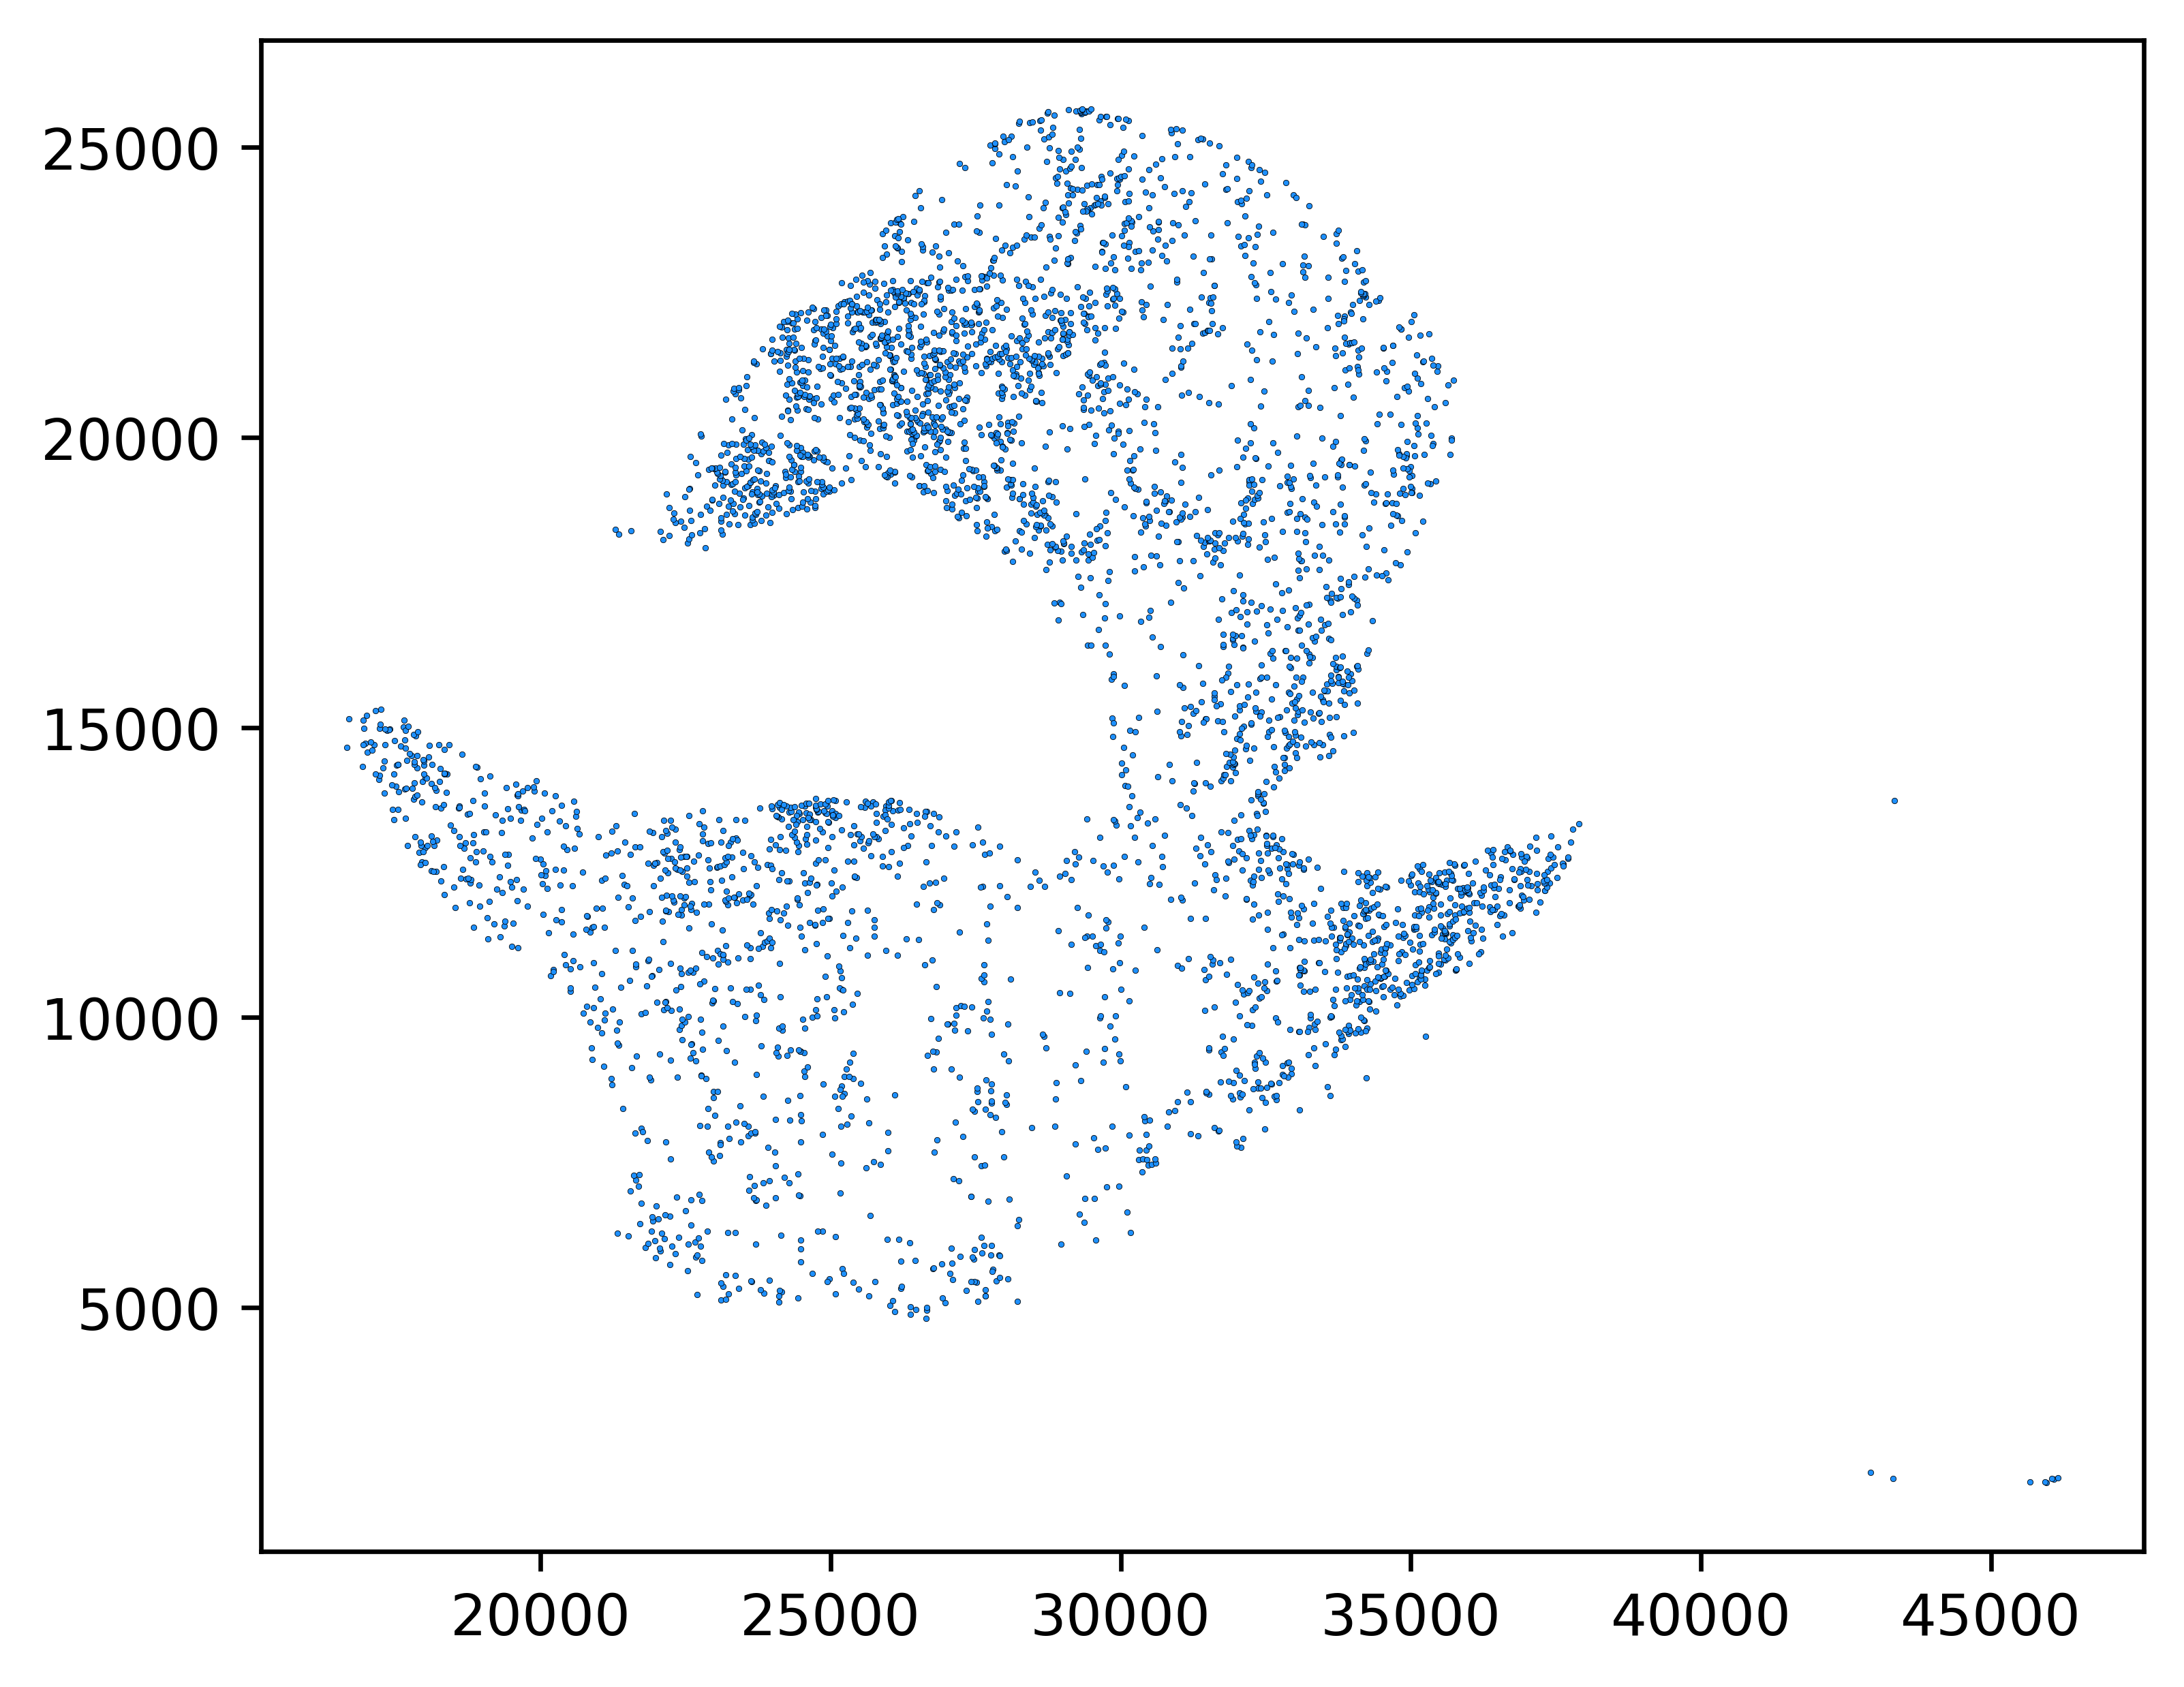

In [6]:
plt.figure(dpi=600)
cells.plot(ax=plt.gca(), markersize=1, edgecolor="black", linewidth=0.1, color="dodgerblue")
#anno.plot(color="None", edgecolor="black")

In [3]:
excl_ln = True
reg_only = False
all_reg = True
t_filt = False

if t_filt: # .STDifference(a.ganno.STBuffer(-500))
    t_anno_sql = f"""
        a.ganno.STBuffer(500).STIntersection(b.ganno)
        """
else:
    t_anno_sql = f"""
    b.ganno
    """

if excl_ln:
    ln_anno_sql = f""".STDifference(c.ganno)"""
else:
    ln_anno_sql = ""

if reg_only:
    reg_anno_sql = f""".STIntersection(d.ganno)"""
else:
    reg_anno_sql = ""

if all_reg:
    all_reg_sql = f""".STUnion(d.ganno).STIntersection(b.ganno)"""
else:
    all_reg_sql = ""

In [4]:
sql = f"""
select b.sampleid,
CASE
    when a.lname is not NULL and d.lname is not NULL and c.lname is not NULL then {t_anno_sql}{reg_anno_sql}{all_reg_sql}{ln_anno_sql}
    when a.lname is not NULL and d.lname is not NULL and c.lname is NULL then {t_anno_sql}{reg_anno_sql}{all_reg_sql}
    when a.lname is not NULL and d.lname is NULL and c.lname is not NULL then {t_anno_sql}{ln_anno_sql}
    when a.lname is not NULL and d.lname is NULL and c.lname is NULL then {t_anno_sql}
    when a.lname is NULL and c.lname is not NULL then b.ganno{reg_anno_sql}{ln_anno_sql}
    when a.lname is NULL and c.lname is NULL then b.ganno{reg_anno_sql}
END anno
from dbo.annotations b
left join dbo.annotations a on b.sampleid = a.sampleid and a.lname = 'tumor'
left join dbo.annotations c on b.sampleid = c.sampleid and c.lname = 'lymph node'
left join dbo.annotations d on b.sampleid = d.sampleid and d.lname = 'regression'
where b.sampleid in (125, 101, 130, 100, 543, 121, 135, 566, 128, 143, 107)
and b.lname = 'good tissue'
"""
areas = d.query(sql)

areas["area"] = [gpd.GeoSeries(loads(x)).area[0]*2.5e-7 for x in areas["anno"]]

# CASE
#     WHEN a.lname is not NULL and d.lname is not NULL and c.lname is not NULL THEN {t_anno_sql}{reg_anno_sql}{all_reg_sql}{ln_anno_sql}.STArea()*2.5e-7
#     WHEN a.lname is not NULL and d.lname is not NULL and c.lname is NULL THEN {t_anno_sql}{reg_anno_sql}{all_reg_sql}.STArea()*2.5e-7
#     WHEN a.lname is not NULL and d.lname is NULL and c.lname is not NULL THEN {t_anno_sql}{ln_anno_sql}.STArea()*2.5e-7
#     WHEN a.lname is not NULL and d.lname is NULL and c.lname is NULL THEN {t_anno_sql}.STArea()*2.5e-7
#     WHEN a.lname is NULL and c.lname is not NULL THEN b.ganno{reg_anno_sql}{ln_anno_sql}.STArea()*2.5e-7
#     WHEN a.lname is NULL and c.lname is NULL THEN b.ganno{reg_anno_sql}.STArea()*2.5e-7
# END area

In [5]:
areas

,sampleid,anno,area
0,100,"MULTIPOLYGON (((5950 26061, 5964 26061, 5968 2...",9.060014
1,101,MULTIPOLYGON (((43877.278998948095 1982.205138...,145.320547
2,107,"POLYGON ((31247 3208, 32365 3394, 32923 3535, ...",294.156110
3,121,"MULTIPOLYGON (((9917 15616, 9921 15616, 9921 1...",1.087728
4,125,"POLYGON ((24548 2807, 24955 2807, 25332 2861, ...",190.544954
5,128,MULTIPOLYGON (((23014.000000000102 33493.00000...,0.229160
6,130,"MULTIPOLYGON (((4428 21824, 4530 21904, 4534 2...",1.932402
7,135,"MULTIPOLYGON (((10611 16269, 10617 16269, 1061...",7.894559
8,143,"POLYGON ((31270 2387, 31456 2395, 31536 2435, ...",228.767876
9,543,"POLYGON ((35474 21342, 35516 21398, 35528 2142...",19.548337


NameError: name 'cells' is not defined

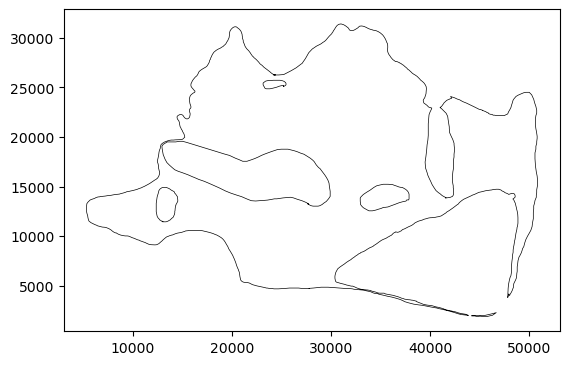

In [6]:
gpd.GeoSeries(loads(areas["anno"][1])).plot(color="None", edgecolor="black", linewidth=0.5)
cells.plot(ax=plt.gca(), markersize=1, edgecolor="black", linewidth=0.1, color="dodgerblue")

In [29]:
sql = f"""
select b.sampleid, b.ganno gt, c.ganno ln, d.ganno reg, a.ganno tum
from dbo.annotations b
left join dbo.annotations a on b.sampleid = a.sampleid and a.lname = 'tumor'
left join dbo.annotations c on b.sampleid = c.sampleid and c.lname = 'lymph node'
left join dbo.annotations d on b.sampleid = d.sampleid and d.lname = 'regression'
where b.lname = 'good tissue'
"""
areas = d.query(sql)

areas["gt"] = [gpd.GeoSeries(loads(x)) if x != "Null" else "Null" for x in areas["gt"]]
areas["tum"] = [gpd.GeoSeries(loads(x)) if x != "Null" else "Null" for x in areas["tum"]]
areas["reg"] = [gpd.GeoSeries(loads(x)) if x != "Null" else "Null" for x in areas["reg"]]
areas["ln"] = [gpd.GeoSeries(loads(x)) if x != "Null" else "Null" for x in areas["ln"]]

# areas["area"] = areas.apply(lambda row: row["tum"].buffer(500).union(row["reg"]).intersection(row["gt"]).difference(row["ln"]) if all([row["tum"] != "Null", row["reg"] != "Null", row["ln"] != "Null"]) else "Pending" )

areas["area"] = areas.apply(
    lambda row: row["tum"].buffer(500).union(row["reg"]).intersection(row["gt"]).difference(row["ln"]) 
    if isinstance(row["tum"]) is not None and row["reg"] is not None and row["ln"] is not None 
    else "Pending", 
    axis=1
)


#     when a.lname is not NULL and d.lname is not NULL and c.lname is NULL then {t_anno_sql}{reg_anno_sql}{all_reg_sql}
#     when a.lname is not NULL and d.lname is NULL and c.lname is not NULL then {t_anno_sql}{ln_anno_sql}
#     when a.lname is not NULL and d.lname is NULL and c.lname is NULL then {t_anno_sql}
#     when a.lname is NULL and c.lname is not NULL then b.ganno{reg_anno_sql}{ln_anno_sql}
#     when a.lname is NULL and c.lname is NULL then b.ganno{reg_anno_sql}
# END anno

TypeError: (<class 'geopandas.geoseries.GeoSeries'>, <class 'str'>)

In [20]:
areas

,sampleid,gt,ln,reg,tum
0,100,"MULTIPOLYGON (((5950 26061, 5964 26061, 5968 2...",Null,Null,"MULTIPOLYGON (((6622 22577, 6660 22577, 6692 2..."
1,101,"POLYGON ((45344 1858, 45718 1858, 46059 1946, ...","MULTIPOLYGON (((12972 11434, 13032 11434, 1309...",MULTIPOLYGON (((31098.516129032312 25178.35483...,"MULTIPOLYGON (((33346 9811, 33356 9817, 33370 ..."
2,102,"MULTIPOLYGON (((47537 7063, 47598 7103, 47543 ...",Null,"MULTIPOLYGON (((33045 1925, 33037 1935, 33013 ...","MULTIPOLYGON (((35061 2465, 35061 2469, 35063 ..."
3,103,"MULTIPOLYGON (((17205 9064, 17432 9074, 17629 ...",Null,"MULTIPOLYGON (((31300.000000000007 18890, 3129...","MULTIPOLYGON (((33862 23912, 33870 23912, 3387..."
4,104,"MULTIPOLYGON (((21954 4411, 21958 4411, 21960 ...",Null,Null,"MULTIPOLYGON (((21954 4411, 21958 4411, 21960 ..."
...,...,...,...,...,...
92,562,"POLYGON ((12022 2566, 12074 2570, 12130 2612, ...","MULTIPOLYGON (((33218 14654, 33307 14654, 3335...",Null,"MULTIPOLYGON (((22109 32649, 22139 32649, 2215..."
93,563,"POLYGON ((11539 1787, 11791 1787, 11857 1797, ...","POLYGON ((11539 1787, 11791 1787, 11857 1797, ...",Null,"POLYGON ((11539 1787, 11791 1787, 11857 1797, ..."
94,564,"POLYGON ((31652 2269, 31771 2279, 31843 2279, ...","POLYGON ((16376 5041, 16432 5060, 16450 5070, ...","POLYGON ((5118 31130, 5196 31130, 5256 31134, ...","MULTIPOLYGON (((4973 33134, 4993 33134, 5017 3..."
95,565,"MULTIPOLYGON (((7169 21905, 7187 21905, 7241 2...","MULTIPOLYGON (((7169 21905, 7187 21905, 7241 2...",MULTIPOLYGON (((30603.800904977503 37754.80542...,"MULTIPOLYGON (((27685 37775, 27885 37777, 2801..."


In [16]:
from get_cell_den import get_cell_den
from anno_check import anno_check
from get_cell_coords import get_cell_coords
from plot_cells import plot_cells

In [4]:
gt_samples = anno_check("good tissue", d)
gt_samples

[100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 137,
 138,
 139,
 140,
 141,
 143,
 144,
 145,
 146,
 148,
 149,
 150,
 151,
 165,
 166,
 167,
 169,
 170,
 171,
 172,
 173,
 174,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 194,
 195,
 196,
 197,
 198,
 199,
 521,
 523,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 560,
 561,
 562,
 563,
 564,
 565,
 566]

In [5]:
d.query("select * from dbo.annotations where sampleid = 173")

,annoid,sampleID,layer,lname,color,isVisible,ganno,ganno2,ganno3
0,1730001,173,1,good tissue,0xffff00,True,"MULTIPOLYGON (((59156 23878, 59172 23878, 5918...",MULTIPOLYGON (((59155.999999999956 23878.00000...,MULTIPOLYGON (((59156.000000000015 23878.00000...
1,1730002,173,2,tumor,0x00ff00,True,"MULTIPOLYGON (((57282 28284, 57284 28284, 5728...","MULTIPOLYGON (((57743.000000000022 28254, 5777...","MULTIPOLYGON (((57743.000000000007 28254, 5762..."
2,1730003,173,3,lymph node,0xff0000,True,"MULTIPOLYGON (((59158 23882, 59174 23882, 5918...","MULTIPOLYGON (((59158 23882, 59292 23882, 5958...","MULTIPOLYGON (((59158 23882, 60332 23990, 6081..."
3,1730007,173,7,outline,0xffffff,True,"MULTIPOLYGON (((33706 29695, 33721 29695, 3373...","MULTIPOLYGON (((33706 29695, 33842 29697, 3395...",MULTIPOLYGON (((48775.575221238985 31189.09337...


In [7]:
get_cell_den(pheno="CD8", sampleid=101, tdist_filter=500, all_reg=True, excl_ln=True)

Querying wsi02...
Counting cells...
Calculating areas...
Done.


,sampleid,phenotype,exprphenotype,c,anno,area,density,filters
0,101,CD8,0,45823,MULTIPOLYGON (((43084.106644917265 13485.86913...,55.215183,829.898539,"tdist:(500, None)_all_reg:True_reg_only:False_..."
1,101,CD8,4,15370,MULTIPOLYGON (((43084.106644917265 13485.86913...,55.215183,278.365462,"tdist:(500, None)_all_reg:True_reg_only:False_..."
2,101,CD8,64,49678,MULTIPOLYGON (((43084.106644917265 13485.86913...,55.215183,899.716292,"tdist:(500, None)_all_reg:True_reg_only:False_..."
3,101,CD8,68,5154,MULTIPOLYGON (((43084.106644917265 13485.86913...,55.215183,93.343890,"tdist:(500, None)_all_reg:True_reg_only:False_..."
4,101,CD8,Total,116025,MULTIPOLYGON (((43084.106644917265 13485.86913...,55.215183,2101.324182,"tdist:(500, None)_all_reg:True_reg_only:False_..."


In [27]:
wsi06 = get_cell_den(pheno="Tumor", sampleid=714, tdist_filter=500, all_reg=True, excl_ln=True, database="wsi06")

Querying wsi06...
Counting cells...
Calculating areas...
Done.


In [28]:
wsi06_cells = get_cell_coords(sampleid=714, pheno="Tumor", database="wsi06", tdist_filter=500, all_reg=True, excl_ln=True)

Querying wsi06, 714 Tumor.


<Axes: >

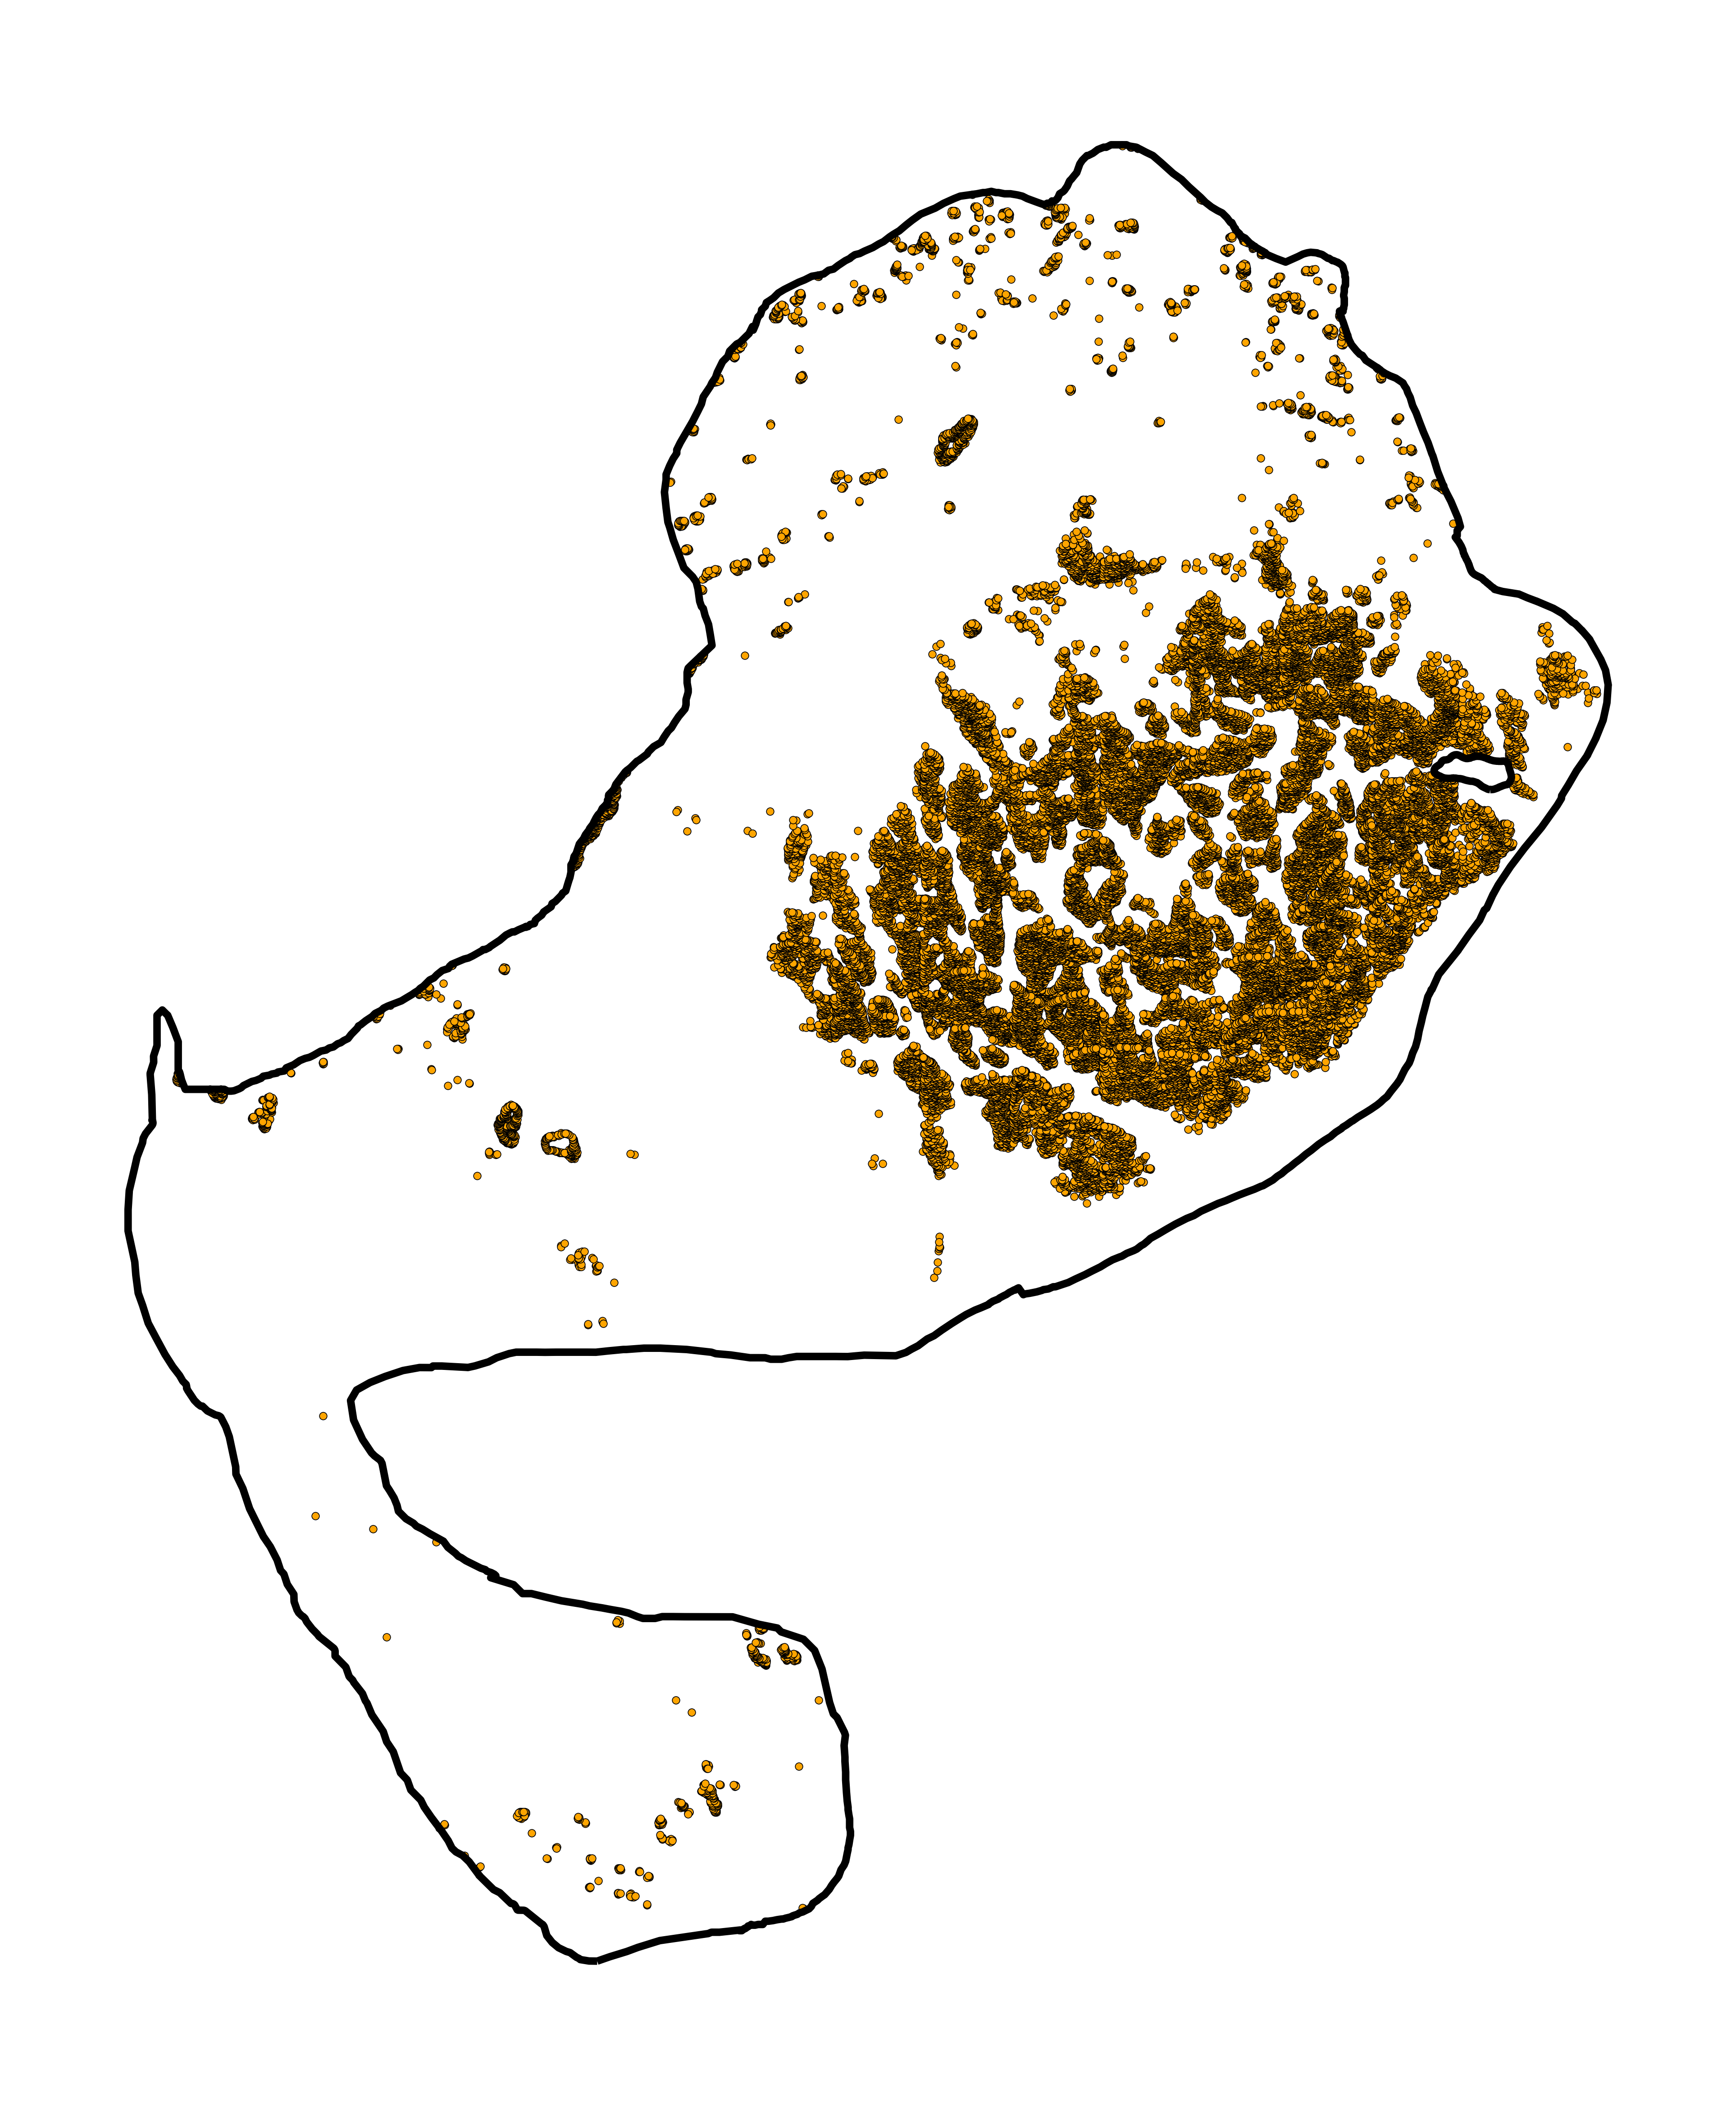

In [30]:
plot_cells(pheno="Tumor", sample=714, colour="orange", x=wsi06_cells["px"], y=wsi06_cells["py"], mpl=True)
gpd.GeoSeries(loads(wsi06["anno"][0])).plot(ax=plt.gca(), edgecolor="black", color="None")

In [8]:
# Get areas for donut density calculation (all on-tx with tumour, use all gt)

area_list = []
for sample in gt_samples:
    print(sample)
    areas = get_cell_den(pheno="CD8", sampleid=sample, tdist_filter=(500), excl_ln=True, all_reg=True)
    area_list.append(areas)
areas = pd.concat(area_list).reset_index(drop=True)

100
Querying wsi02...
Counting cells...
Calculating areas...
Done.
101
Querying wsi02...
Counting cells...
Calculating areas...
Done.
102
Querying wsi02...
Counting cells...
Calculating areas...
Done.
103
Querying wsi02...
Counting cells...
Calculating areas...
Done.
104
Querying wsi02...
Counting cells...
Calculating areas...
Done.
105
Querying wsi02...
Counting cells...
Calculating areas...
Done.
106
Querying wsi02...
Counting cells...
Calculating areas...
Done.
107
Querying wsi02...
Counting cells...
Calculating areas...
Done.
108
Querying wsi02...
Counting cells...
Calculating areas...
Done.
109
Querying wsi02...
Counting cells...
Calculating areas...
Done.
110
Querying wsi02...
Counting cells...
Calculating areas...
Done.
112
Querying wsi02...
Counting cells...
Calculating areas...
Done.
113
Querying wsi02...
Counting cells...
Calculating areas...
Done.
114
Querying wsi02...
Counting cells...
Calculating areas...
Done.
115
Querying wsi02...
Counting cells...
Calculating areas...
D

C:\Users\Michael\AppData\Local\Temp\ipykernel_19232\3022391315.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  areas = pd.concat(area_list).reset_index(drop=True)


In [10]:
areas_df = areas[areas["exprphenotype"] == "Total"].reset_index(drop=True)
areas_df

,sampleid,phenotype,exprphenotype,c,anno,area,density
0,100,CD8,Total,1021,"MULTIPOLYGON (((5950 26061, 5964 26061, 5968 2...",8.551418,119.395409
1,101,CD8,Total,116025,MULTIPOLYGON (((43084.106644917265 13485.86913...,55.215183,2101.324182
2,102,CD8,Total,40699,"POLYGON ((35313 1738, 35371.666666666591 1738....",47.870352,850.192201
3,103,CD8,Total,48855,"POLYGON ((42518 6682, 42554 6682, 42597 6688, ...",56.062425,871.439294
4,104,CD8,Total,78,"MULTIPOLYGON (((21954 4411, 21958 4411, 21960 ...",0.486904,160.195932
...,...,...,...,...,...,...,...
89,561,CD8,Total,34972,"MULTIPOLYGON (((37234.000000000095 39987, 3724...",49.143131,711.635567
90,562,CD8,Total,174,"MULTIPOLYGON (((18786 35066, 18830.73626065743...",3.535320,49.217616
91,564,CD8,Total,2718,"POLYGON ((5118 31130, 5196 31130, 5256 31134, ...",2.101172,1293.564051
92,565,CD8,Total,159,MULTIPOLYGON (((22870.626506017965 39496.62650...,0.147788,1075.863533


In [28]:
areas_df.to_excel("../donut_on_areas.xlsx")

In [11]:
samples_df = d.query("select distinct sampleid from dbo.celltag")
samples_df

,sampleid
0,139
1,523
2,149
3,534
4,101
...,...
92,129
93,143
94,536
95,104


In [13]:
missing = samples_df[~samples_df.isin(areas_df["sampleid"].to_list())]
missing = missing[~missing["sampleid"].isna()]
missing

,sampleid
20,551.0
61,173.0
79,563.0


In [11]:
missing_samps = d.query(f"""select top 10 * from dbo.celltag where sampleid in ({",".join(map(str, missing["sampleid"]))})""")
missing_samps

,cellid,sampleid,hpfid,px,py,ptype,CMembrane520,CMembrane540,CNucleus570,CCytoMembrane620,CMembrane650,CMembrane690,exprPhenotype,tdist,rdist,pos,PDL1,PD1
0,551001200010,551,5510012,20191.916185,6429.066216,1,5.176547,4.209934,6.541454,1.391298,39.46062,1.587419,64,10369.61,32768,POINT (20191.916184606933 6429.0662157371416),False,True
1,551001200018,551,5510012,20223.916185,6341.066216,1,9.062572,9.653477,2.743659,2.995549,18.06792,1.528819,64,10462.86,32768,POINT (20223.916184606933 6341.0662157371416),False,True
2,551001200031,551,5510012,20278.916185,6446.066216,5,9.322845,5.530571,20.620370,4.769071,28.10982,1.008749,64,10391.66,32768,POINT (20278.916184606933 6446.0662157371416),False,True
3,551001200032,551,5510012,20204.916185,6448.066216,1,5.973032,2.926285,3.651167,3.702118,18.95582,1.437781,68,10357.98,32768,POINT (20204.916184606933 6448.0662157371416),True,True
4,551001200033,551,5510012,20362.916185,6461.066216,1,10.025340,4.220813,1.298515,3.248909,12.93720,0.984681,4,10414.89,32768,POINT (20362.916184606933 6461.0662157371416),True,False
5,551001200050,551,5510012,20268.916185,6332.066216,2,6.277889,0.065270,49.226020,10.463130,20.45776,0.940731,64,10490.21,32768,POINT (20268.916184606933 6332.0662157371416),False,True
6,551001200052,551,5510012,20277.916185,6351.066216,2,6.623715,0.043514,13.722260,6.910621,16.42484,1.195011,64,10476.91,32768,POINT (20277.916184606933 6351.0662157371416),False,True
7,551001200055,551,5510012,20288.916185,6352.066216,2,5.201851,0.039162,16.694440,3.703210,13.06990,0.998284,68,10480.75,32768,POINT (20288.916184606933 6352.0662157371416),True,True
8,551001200056,551,5510012,20318.916185,6354.066216,2,2.414758,0.000000,67.674720,18.263780,44.35369,1.046420,64,10491.90,32768,POINT (20318.916184606933 6354.0662157371416),False,True
9,551001200059,551,5510012,20080.916185,6387.066216,2,3.594423,0.073973,28.525070,5.630714,20.67973,1.726592,64,10360.98,32768,POINT (20080.916184606933 6387.0662157371416),False,True


In [14]:
missing_annos = d.query(f"""select * from dbo.annotations where sampleid in ({",".join(map(str, missing["sampleid"]))})""")
missing_annos

,annoid,sampleID,layer,lname,color,isVisible,ganno,ganno2,ganno3
0,1730001,173,1,good tissue,0xffff00,True,"MULTIPOLYGON (((59156 23878, 59172 23878, 5918...",MULTIPOLYGON (((59155.999999999956 23878.00000...,MULTIPOLYGON (((59156.000000000015 23878.00000...
1,1730002,173,2,tumor,0x00ff00,True,"MULTIPOLYGON (((57282 28284, 57284 28284, 5728...","MULTIPOLYGON (((57743.000000000022 28254, 5777...","MULTIPOLYGON (((57743.000000000007 28254, 5762..."
2,1730003,173,3,lymph node,0xff0000,True,"MULTIPOLYGON (((59158 23882, 59174 23882, 5918...","MULTIPOLYGON (((59158 23882, 59292 23882, 5958...","MULTIPOLYGON (((59158 23882, 60332 23990, 6081..."
3,1730007,173,7,outline,0xffffff,True,"MULTIPOLYGON (((33706 29695, 33721 29695, 3373...","MULTIPOLYGON (((33706 29695, 33842 29697, 3395...",MULTIPOLYGON (((48775.575221238985 31189.09337...
4,5510001,551,1,good tissue,0xffff00,True,"MULTIPOLYGON (((10689 21459, 10693 21463, 1069...",MULTIPOLYGON (((10385.000000000111 14424.00000...,MULTIPOLYGON (((10385.000000000111 14424.00000...
5,5510002,551,2,tumor,0x00ff00,True,"MULTIPOLYGON (((8912 23945, 8918 23947, 8924 2...","MULTIPOLYGON (((8912 23945, 8942 23971, 8942 2...","MULTIPOLYGON (((8912 23945, 8942 24001, 8902 2..."
6,5510003,551,3,lymph node,0xff0000,True,"MULTIPOLYGON (((10365 14224, 10735 14224, 1076...","MULTIPOLYGON (((10365 14224, 10735 14224, 1094...","MULTIPOLYGON (((10365 14224, 10735 14224, 1111..."
7,5510007,551,7,outline,0xffffff,True,"MULTIPOLYGON (((7669 30126, 7683 30126, 7694 3...","MULTIPOLYGON (((7669 30126, 7717 30143, 7722 3...",MULTIPOLYGON (((7669.0000000001291 30125.99999...
8,5630001,563,1,good tissue,0xffff00,True,"POLYGON ((11539 1787, 11791 1787, 11857 1797, ...","POLYGON ((11539 1787, 12158 1797, 12381 1832, ...","POLYGON ((11539 1787, 12381 1832, 12888 1991, ..."
9,5630002,563,2,tumor,0x00ff00,True,"POLYGON ((11539 1787, 11791 1787, 11857 1797, ...","POLYGON ((11539 1787, 12158 1797, 12381 1832, ...","POLYGON ((11539 1787, 12381 1832, 12888 1991, ..."


In [ ]:
# These samples have no area when ln is excluded, add a few lines in the function to re-add empty rows